In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import emcee
import astropy
from astropy.io import ascii
from astropy import units
from astropy.coordinates import SkyCoord

In [2]:
import modKI17

# utilities

In [3]:
def sdss_to_des_Y1A1(g_sdss,r_sdss,i_sdss,z_sdss,y_sdss):
    """
    transfrom equation given by [arXiv:1708.01531].
    """
    ret = {}
    ret["g_des"] = g_sdss - 0.104*(g_sdss-r_sdss) + 0.01
    ret["r_des"] = g_sdss - 0.102*(g_sdss-r_sdss) + 0.02
    ret["i_des"] = i_sdss - 0.256*(i_sdss-z_sdss) + 0.02
    ret["z_des"] = z_sdss - 0.086*(i_sdss-z_sdss) + 0.01
    ret["y_des"] = y_sdss + 0.238*(z_sdss-y_sdss) + 0.483
    ret["VALID"] = (g_sdss - r_sdss < 1.2)["G-R_SDSS"]<1.2
    
    return ret

def des_to_sdss_Y1A1(g_des,r_des,i_des,z_des,y_des):
    """
    transfrom equation given by the inversion of [arXiv:1708.01531].
    """
    ret = {}
    ret["g_sdss"] = 1.104*g_des - 0.1042*r_des - 0.008958
    ret["r_sdss"] = 0.1022*g_des + 0.8978*r_des - 0.01898
    ret["i_sdss"] = 1.308*i_des - 0.3084*z_des - 0.02308
    ret["z_sdss"] = 0.1036*i_des + 0.8964*z_des - 0.01104
    ret["y_sdss"] = -0.03236*i_des + 1.312*y_des - 0.28*z_des - 0.6304
    ret["VALID"] = (ret["g_sdss"] - ret["r_sdss"] < 1.2)
    
    return ret

def des_to_sdss_DR1(g_des,r_des,i_des,z_des):
    """
    conversion equation given by:
    https://des.ncsa.illinois.edu/releases/dr1/dr1-faq
    """
    gmi_des = g_des-i_des
    ret = {}
    ret["g_sdss"] = g_des -0.0009 + 0.055*gmi_des # 0.0 <= (g-i)(DES) <= 3.0
    ret["r_sdss"] = r_des -0.0048 + 0.0703*gmi_des #0.0 <= (g-i)(DES) <= 3.0
    ret["i_sdss"] = i_des -0.0065 - 0.0036*gmi_des + 0.02672*gmi_des**2 # 0.0 <= (g-i)(DES) <= 3.0
    ret["z_sdss"] = z_des -0.0438 + 0.02854*gmi_des #0.0 <= (g-i)(DES) <= 3.0
    ret["VALID"] = np.logical_and(0.0<gmi_des,gmi_des<=3.0)
    
    return ret
    
def Johnson_to_sdss_Jordi2006(u_Johnson,b_Johnson,v_Johnson,r_Johnson,i_Johnson):
    U,B,V,R,I = u_Johnson,b_Johnson,v_Johnson,r_Johnson,i_Johnson
    ret = {}
    ret["u-g"]   =      0.750 *(U-B)  + 0.770 *(B-V) + 0.720
    ret["g-V"]   =      0.630 *(B-V)  - 0.124
    ret["g-B"]   =     -0.370 *(B-V)  - 0.124
    ret["g-r"]   =      1.646 *(V-R)  - 0.139
    ret["g-i"]   =     (1.481 *(V-I)  -  0.536)*(V-I <= 1.8) +  (0.83 *(V-I)    + 0.60)*(V-I > 1.8)
    ret["r-i"]   =     1.007*(R-I)  - 0.236 
    ret["r-z"]   =     1.584*(R-I)  - 0.386
    ret["r-R"]   =     (0.267*(V-R)  + 0.088)*(V-R <= 0.93) +  (0.77*(V-R)    - 0.37)*(V-R > 0.93)
    ret["i-I"]   =     0.247*(R-I)  + 0.329
    return ret

def sdss_to_Johnson_Jordi2006(u_sdss,g_sdss,r_sdss,i_sdss,z_sdss):
    u,g,r,i,z = u_sdss,g_sdss,r_sdss,i_sdss,z_sdss
    ret = {}
    ret["U-B_1"]   =      0.79*(u-g)    - 0.93
    ret["U-B_2"]   =      0.52*(u-g)    + 0.53*(g-r) - 0.82
    ret["B-g_1"]   =      0.175*(u-g)  + 0.150
    ret["B-g_2"]   =      0.313*(g-r)  + 0.219
    ret["V-g"]   =     -0.565*(g-r) - 0.016
    ret["V-I"]   =     (0.675*(g-i)  + 0.364)*(g-i <= 2.1)  + (1.11*(g-i)  - 0.52)*(g-i > 2.1)
    ret["R-r"]   =     -0.153*(r-i) - 0.117
    ret["R-I"]   =      0.930*(r-i)  + 0.259
    ret["I-i"]   =     -0.386*(i-z) - 0.397
    
    ret["R_Johnson"] = ret["R-r"] + r_sdss
    ret["I_Johnson"] = ret["I-i"] + i_sdss
    ret["B_Johnson"] = ret["B-g_1"] + g_sdss
    ret["V_Johnson"] = ret["V-g"] + g_sdss
    ret["U_Johnson"] = ret["U-B_1"] + ret["B_Johnson"]
    
    return ret

def sdss_to_Johnson_Jester2005(u_sdss,g_sdss,r_sdss,i_sdss,z_sdss):
    """
    transform equation given by: 
        https://www.sdss.org/dr12/algorithms/sdssUBVRITransform/#Jester2005
    or
        https://arxiv.org/pdf/astro-ph/0506022.pdf
    
    NOTE: Here we use the relation for 
        "All stars with Rc-Ic < 1.15".
        
    Also note that the following equations are degenerated (5 parameters, but 6 equation)
    """
    ret = {}
    ret["U-B"]    =    0.78*(u_sdss-g_sdss) - 0.88        # res 0.05
    ret["B-V"]    =    0.98*(g_sdss-r_sdss) + 0.22        # res 0.04
    ret["V-R"]    =    1.09*(r_sdss-i_sdss) + 0.22        # res 0.03
    ret["Rc-Ic"]  =    1.00*(r_sdss-i_sdss) + 0.21        # res 0.01
    
    ret["B_Johnson"]      =    g_sdss + 0.39*(g_sdss-r_sdss) + 0.21    # res 0.03
    ret["V_Johnson"]      =    g_sdss - 0.59*(g_sdss-r_sdss) - 0.01    # res 0.01
    
    ret["U_Johnson"] = ret["U-B"] + ret["B_Johnson"]
    ret["I_Johnson"] =  -ret["Rc-Ic"] - ret["V-R"] + ret["V_Johnson"] 
    ret["R_Johnson"] = ret["V_Johnson"] - ret["V-R"]
    ret["VALID"]  =    ret["Rc-Ic"] < 1.15
    
    return ret

def Johnson_to_sdss_Jester2005(u_Johnson,b_Johnson,v_Johnson,r_Johnson,i_Johnson):
    """
    transform equation given by: 
        https://www.sdss.org/dr12/algorithms/sdssUBVRITransform/#Jester2005
    or
        https://arxiv.org/pdf/astro-ph/0506022.pdf
    
    NOTE: Here we use the relation for 
        "All stars with Rc-Ic < 1.15".
        
    Also note that the following equations are degenerated (5 parameters, but 6 equation)
    """
    ret = {}
    ret["u-g"]    =    1.28*(u_Johnson-b_Johnson) + 1.13      #res 0.06
    ret["g-r"]    =    1.02*(b_Johnson-v_Johnson) - 0.22      #res 0.04
    ret["r-i"]    =    0.91*(r_Johnson-i_Johnson) - 0.20      #res 0.03
    ret["r-z"]    =    1.72*(r_Johnson-i_Johnson) - 0.41      #res 0.03
    ret["g"]      =    v_Johnson + 0.60*(b_Johnson-v_Johnson) - 0.12    #res 0.02
    ret["r"]      =    v_Johnson - 0.42*(b_Johnson-v_Johnson) + 0.11    #res 0.03
    ret["VALID"]  =    r_Johnson-i_Johnson < 1.15
    return ret

def sdss_to_Johnson(u_sdss,g_sdss,r_sdss,i_sdss,z_sdss,table="Jordi2006"):
    func = {
        "Jordi2006" :sdss_to_Johnson_Jordi2006,
        "Jester2005":sdss_to_Johnson_Jester2005
    }
    return func[table](u_sdss,g_sdss,r_sdss,i_sdss,z_sdss)

# Data Info
## Walker

In [4]:
cds_walker = ascii.read("data/aj283181t4_mrt.txt",format="cds")
display(cds_walker.info())

df_walker_raw = cds_walker.to_pandas()
rastr = df_walker_raw.apply(lambda data: "{:0>2}h{}m{}s".format(data.RAh,data.RAm,data.RAs),axis=1)
destr = df_walker_raw.apply(lambda data: "{}{:0>2}d{}m{}s".format(data["DE-"],data.DEd,data.DEm,data.DEs),axis=1)
coords = SkyCoord(ra=rastr,dec=destr)
df_walker_raw["RAdeg"],df_walker_raw["DEdeg"] = coords.ra.deg, coords.dec.deg
df_walker = pd.DataFrame(df_walker_raw)
counts_walker = df_walker_raw.Target.value_counts()
# fill weighted value for single counted objects
for key in ["VHel","SigMg"]:
    w_key = "<{}>".format(key) # weghted key
    e_key = "e_"+key
    e_w_key = "e_"+w_key
    df_walker[w_key] = df_walker.apply(func=(lambda line: line[w_key] if counts_walker[line.Target]>1 else line[key]),axis=1)
    df_walker[e_w_key] = df_walker.apply(func=(lambda line: line[e_w_key] if counts_walker[line.Target]>1 else line[e_key]),axis=1)
df_walker = df_walker[np.logical_not(np.isnan(df_walker["<VHel>"]))]
df_walker

<Table masked=True length=1818>
   name    dtype   unit                   description                   n_bad
--------- ------- ------ ---------------------------------------------- -----
   Target    str8               Target identification; Galaxy-ID number     0
    Field    str4                    Field and spectrograph channel (1)     0
      HJD float64      d         Heliocentric Julian Date minus 2450000     0
      RAh   int64      h                Hour of Right Ascension (J2000)     0
      RAm   int64    min              Minute of Right Ascension (J2000)     0
      RAs float64      s              Second of Right Ascension (J2000)     0
      DE-    str1                       Sign of the Declination (J2000)     0
      DEd   int64    deg                  Degree of Declination (J2000)     0
      DEm   int64 arcmin               Arcminute of Declination (J2000)     0
      DEs float64 arcsec               Arcsecond of Declination (J2000)     0
     Vmag float64    mag        

None

Target Field       HJD  RAh  RAm    RAs DE-  DEd  DEm   DEs  \
0     Scl-0001   20B  3286.629    1    0  46.17   -   33   39  19.6   
2     Scl-0002   20B  3286.629    1    0  45.44   -   33   39  59.9   
4     Scl-0003   20B  3286.629    1    0  44.46   -   33   41  54.1   
6     Scl-0004   20B  3286.629    1    0  46.96   -   33   43  19.9   
9     Scl-0005   20B  3286.629    1    0  42.44   -   33   43  26.0   
13    Scl-0006   20B  3286.629    1    0  44.88   -   33   43  57.7   
15    Scl-0007   20B  3286.629    1    0  42.07   -   33   44   2.7   
16    Scl-0008   20B  3286.629    1    0  51.01   -   33   38  20.5   
18    Scl-0009   20B  3286.629    1    0  50.99   -   33   40   2.4   
20    Scl-0010   20B  3286.629    1    0  49.48   -   33   40  37.8   
22    Scl-0011   20B  3286.629    1    0  51.15   -   33   47  17.3   
24    Scl-0012   20B  3286.629    1    0  51.95   -   33   46  24.0   
27    Scl-0013   20B  3286.629    1    0  58.45   -   33   46  13.9   
30    Scl-0014   20B  3286.629    1    0  59.87   -   33   45  22.2   
31    Scl-0015   20B  3286.629    1    1   2.97   -   33   45  13.6   
32    Scl-0016   20B  3286.629    1    1   5.90   -   33   44  15.0   
33    Scl-0017   20B  3286.629    1    1   9.27   -   33   43  36.5   
35    Scl-0018   20B  3286.629    1    0  44.85   -   33   45  32.1   
37    Scl-0019   20B  3286.629    1    0  46.10   -   33   44  42.9   
39    Scl-0020   20B  3286.629    1    0  59.92   -   33   44  54.1   
40    Scl-0021   20B  3286.629    1    0  49.80   -   33   44  18.0   
41    Scl-0022   20B  3286.629    1    0  55.11   -   33   44  15.2   
43    Scl-0023   20B  3286.629    1    0  56.11   -   33   44   0.7   
45    Scl-0024   20B  3286.629    1    1   4.89   -   33   43  40.0   
46    Scl-0025   20B  3286.629    1    0  56.58   -   33   40  36.7   
48    Scl-0026   20B  3286.629    1    0  55.27   -   33   40  42.7   
50    Scl-0027   20B  3286.629    1    0  52.92   -   33   40  44.3   
51    Scl-0028   20B  3286.629    1    0  55.58   -   33   41   2.3   
54    Scl-0029   20B  3286.629    1    0  56.26   -   33   41  31.9   
56    Scl-0030   20B  3286.629    1    1   3.54   -   33   38  48.5   
...        ...   ...       ...  ...  ...    ...  ..  ...  ...   ...   
1788  Scl-1512    1R  4685.730    1    0  13.63   -   33   46   2.9   
1789  Scl-1513    1R  4685.730    1    0  15.26   -   33   45  49.9   
1790  Scl-1514    1R  4685.730    1    0  26.56   -   33   36   5.3   
1791  Scl-1515    1R  4685.730    1    0  24.06   -   33   39  38.2   
1792  Scl-1516    1R  4685.730    1    0  22.57   -   33   40  44.9   
1793  Scl-1517    1R  4685.730    1    0  24.97   -   33   44   6.0   
1794  Scl-1518    1R  4685.730    1    0  32.53   -   33   36  54.0   
1795  Scl-1519    1R  4685.730    1    0  34.10   -   33   37  15.6   
1796  Scl-1520    1R  4685.730    1    0  35.20   -   33   37  47.1   
1797  Scl-1521    1R  4685.730    1    0  36.00   -   33   39   1.6   
1798  Scl-1522    1R  4685.730    1    0  38.02   -   33   41   5.2   
1799  Scl-1523    1R  4685.730    1    0  46.40   -   33   36  21.6   
1800  Scl-1524    1R  4685.730    1    0  45.05   -   33   38  35.8   
1801  Scl-1525    1R  4685.730    1    0  35.92   -   33   42  35.4   
1802  Scl-1526    1R  4685.730    1    0  33.05   -   33   43   2.3   
1803  Scl-1527    1R  4685.730    1    0  47.95   -   33   42   8.2   
1804  Scl-1528    1R  4685.730    1    1  17.84   -   33   43  21.7   
1805  Scl-1529    1R  4685.730    1    0  32.17   -   33   50   1.6   
1806  Scl-1530    1R  4685.730    1    0  33.05   -   33   48  40.2   
1807  Scl-1531  399B  4686.706    0   55  16.33   -   33   31  33.0   
1808  Scl-1532  399B  4686.706    0   55  21.68   -   33   24   9.7   
1809  Scl-1533  399B  4686.706    0   55  23.45   -   33   24   9.9   
1810  Scl-1534  399B  4686.706    0   55   2.54   -   33   29  32.2   
1811  Scl-1535  399B  4686.706    0   54  57.52   -   33   26  39.5   
1812  Scl-1536  399B  4686.706  

## Coleman

In [5]:
cds_colman = ascii.read("data/datafile7.txt",format="cds")
display(cds_colman.info())
df_colman = cds_colman.to_pandas()
rastr = df_colman.apply(lambda data: "{:0>2}h{}m{}s".format(data.RAh,data.RAm,data.RAs),axis=1)
destr = df_colman.apply(lambda data: "{}{:0>2}d{}m{}s".format(data["DE-"],data.DEd,data.DEm,data.DEs),axis=1)
coords = SkyCoord(ra=rastr,dec=destr)
df_colman["RAdeg"],df_colman["DEdeg"] = coords.ra.deg, coords.dec.deg
df_colman

<Table length=152>
  name    dtype   unit             description           
-------- ------- ------ ---------------------------------
    Star    str9                      Star identification
     RAh   int64      h   Hour of Right Ascension (J2000)
     RAm   int64    min Minute of Right Ascension (J2000)
     RAs float64      s Second of Right Ascension (J2000)
     DE-    str1          Sign of the Declination (J2000)
     DEd   int64    deg     Degree of Declination (J2000)
     DEm   int64 arcmin  Arcminute of Declination (J2000)
     DEs float64 arcsec  Arcsecond of Declination (J2000)
    Vmag float64    mag              The V band magnitude
  e_Vmag float64    mag           Uncertainty in Vmag (1)
     V-I float64    mag                   The (V-I) color
   e_V-I float64    mag            Uncertainty in V-I (1)
    RVel float64 km / s                   Radial velocity
  e_RVel float64 km / s               Uncertainty in RVel
  [Fe/H] float64  [Sun]  Log of the Fe/H number abund

None

Star  RAh  RAm    RAs DE-  DEd  DEm   DEs    Vmag  e_Vmag    V-I  \
0     16_2_265    0   55  21.20   -   34   42  12.6  17.934   0.005  1.232   
1     12_2_332    0   55  21.98   -   34    1  42.4  18.498   0.006  1.097   
2      8_3_296    0   55  23.44   -   33   24   9.9  18.639   0.006  1.173   
3      4_3_158    0   55  37.52   -   32   41  58.0  18.186   0.006  1.260   
4      8_4_235    0   55  55.74   -   33   33  53.3  18.351   0.005  1.146   
5     12_3_139    0   56  12.09   -   34   16  17.7  18.012   0.004  1.199   
6      7_7_306    0   56  20.23   -   33    9  20.9  18.551   0.009  1.158   
7     11_8_435    0   56  46.94   -   33   48  20.6  17.235   0.003  1.480   
8      3_5_175    0   57  15.38   -   32   59  28.4  18.046   0.006  1.277   
9      7_5_285    0   57  19.67   -   33   36  38.0  18.525   0.008  1.129   
10     3_5_138    0   57  31.68   -   32   58  58.3  18.201   0.007  1.261   
11     7_5_227    0   57  32.70   -   33   34   6.9  17.428   0.008  1.362   
12    11_5_233    0   57  33.46   -   34   24  47.7  17.373   0.004  1.364   
13     7_6_139    0   57  50.35   -   33   32   6.8  18.515   0.007  1.184   
14    11_7_120    0   57  55.06   -   33   59  40.9  17.201   0.004  1.449   
15    11_8_109    0   58   4.07   -   33   50  41.8  17.876   0.004  1.375   
16     11_7_72    0   58   5.50   -   33   55  16.3  17.802   0.005  1.252   
17     11_7_29    0   58  14.14   -   33   55  29.3  18.531   0.005  1.185   
18      7_6_38    0   58  15.72   -   33   27  16.2  17.226   0.022  1.454   
19   11_2_1023    0   58  27.30   -   34    1  18.5  17.531   0.005  1.573   
20   11_1_7442    0   58  33.57   -   33   49  39.8  17.838   0.004  1.329   
21   11_1_7421    0   58  33.76   -   33   43  18.6  17.525   0.003  1.449   
22   11_1_7332    0   58  36.12   -   33   40  25.7  17.547   0.005  1.604   
23    7_4_3266    0   58  38.77   -   33   35   2.2  17.802   0.005  1.296   
24   11_1_7248    0   58  39.08   -   33   45  52.4  18.435   0.005  1.240   
25   11_1_7127    0   58  42.58   -   33   48  33.4  17.189   0.004  1.576   
26    11_2_937    0   58  43.13   -   34    3   4.6  18.237   0.006  1.163   
27    7_4_3245    0   58  43.43   -   33   35  57.9  18.691   0.007  1.222   
28   11_1_7102    0   58  43.51   -   33   50  30.8  18.338   0.005  1.250   
29     7_2_287    0   58  45.46   -   33   10   0.4  17.223   0.004  1.477   
..         ...  ...  ...    ...  ..  ...  ...   ...     ...     ...    ...   
122     6_6_34    1    1  35.91   -   33   29   9.3  18.181   0.005  1.265   
123   10_8_128    1    1  39.62   -   33   45   4.3  17.222   0.004  1.604   
124     6_6_12    1    1  45.19   -   33   25  40.0  17.769   0.004  1.304   
125     6_5_27    1    1  49.33   -   33   36  23.9  17.233   0.003  1.505   
126    10_7_22    1    1  49.38   -   33   54   9.9  17.130   0.006  1.507   
127  10_1_2031    1    1  59.91   -   33   51  12.9  17.861   0.005  1.407   
128   10_2_586    1    2   8.04   -   33   57  50.4  17.732   0.005  1.392   
129    6_4_273    1    2  10.16   -   33   36  22.5  18.297   0.006  1.174   
130  10_1_1767    1    2  15.95   -   33   45   1.8  18.242   0.005  1.277   
131    6_3_197    1    2  22.18   -   33   23   4.4  17.108   0.003  1.482   
132    2_3_289    1    2  23.29   -   32   42  57.5  17.873   0.009  1.254   
133  10_1_1614    1    2  23.58   -   33   43  43.8  17.184   0.003  1.547   
134   10_2_515    1    2  23.73   -   33   55  21.9  18.147   0.005  1.345   
135   10_2_511    1    2  24.05   -   33   51  40.5  18.067   0.006  1.316   
136    6_2_159    1    2  33.21   -   33   14  13.2  18.440   0.007  1.140   
137  10_1_1409    1    2  33.87   -   33   38  59.7  18.047   0.005  1.300   
138    6_2_152    1    2  36.12   -   33   10   6.1  17.637   0.004  1.333   
139    6_4_194    1    2  36.57   -   33   38   0.7  18.468   0.007  1.182   
140  10_1_1238    1    2  44.12   -   33   47  21.1  18.633   0.006  1.237   
141     6_3_83    1    3  12.50 

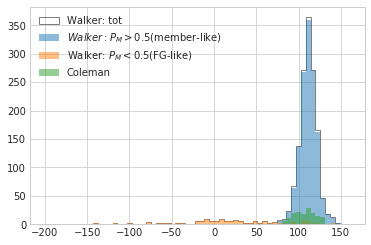

1370

171

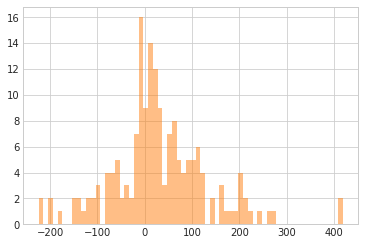

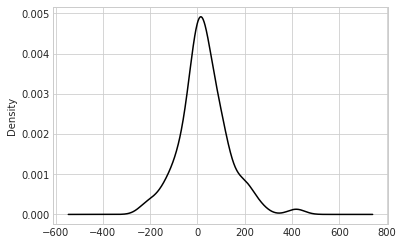

In [283]:
bins=np.linspace(-200,160,64)
df_walker["<VHel>"].hist(bins=bins,alpha=0.5,histtype="step",color="black")
df_walker[df_walker.PM>0.5]["<VHel>"].hist(bins=bins,alpha=0.5)
df_walker[df_walker.PM<0.5]["<VHel>"].hist(bins=bins,alpha=0.5)
df_colman.RVel.hist(bins=bins,alpha=0.5)
plt.legend(["Walker: tot","$Walker: P_M>0.5$(member-like)","Walker: $P_M<0.5$(FG-like)","Coleman"])
plt.show()
display(len(df_walker[df_walker.PM>0.5]),
len(df_walker[df_walker.PM<0.5]))

df_walker[df_walker.PM<0.5]["<VHel>"].hist(bins=64,alpha=0.5,color="C1")
plt.show()
df_walker[df_walker.PM<0.5]["<VHel>"].plot.kde(color="black")
plt.show()

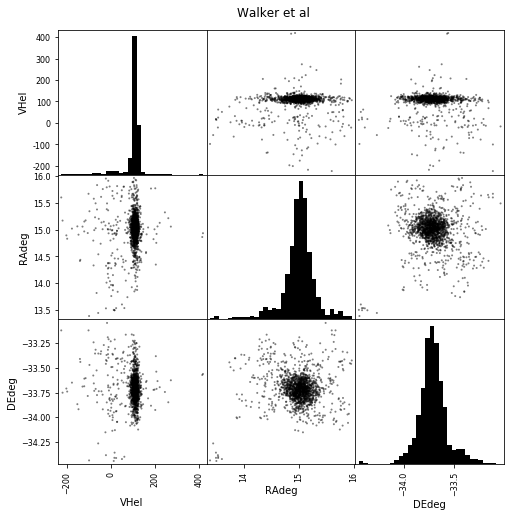

VHel        RAdeg        DEdeg
count  1818.000000  1818.000000  1818.000000
mean    103.180803    15.016665   -33.720684
std      40.507463     0.293688     0.148310
min    -224.400000    13.387875   -34.443389
25%     103.300000    14.919385   -33.798938
50%     110.600000    15.036583   -33.726014
75%     116.800000    15.158167   -33.653035
max     419.200000    15.966625   -33.044611

In [7]:
pd.plotting.scatter_matrix(
    df_walker[["VHel","RAdeg","DEdeg"]],
    s=16,figsize=(8,8),c="black",
    hist_kwds={"bins":32,"color":"black"}
)
plt.suptitle('Walker et al',y=0.92)
plt.show()
#ax.set_title("Walker et al")
display(df_walker_raw[["VHel","RAdeg","DEdeg"]].describe())

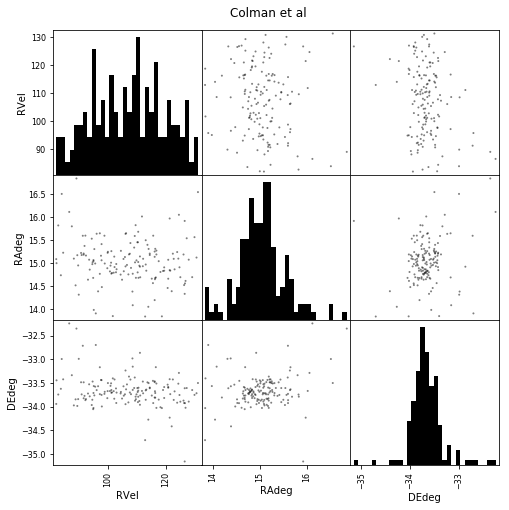

RVel       RAdeg       DEdeg
count  152.000000  152.000000  152.000000
mean   107.211842   15.047061  -33.661553
std     12.335304    0.496320    0.338750
min     82.100000   13.838333  -35.152833
25%     97.200000   14.771719  -33.839118
50%    108.250000   15.034250  -33.689167
75%    116.325000   15.255833  -33.513500
max    131.200000   16.845042  -32.245417

In [8]:
pd.plotting.scatter_matrix(
    df_colman[["RVel","RAdeg","DEdeg"]],
    s=16,figsize=(8,8),c="black",
    hist_kwds={"bins":32,"color":"black"}
)
plt.suptitle('Colman et al',y=0.92)
plt.show()
#ax.set_title("Walker et al")
display(df_colman[["RVel","RAdeg","DEdeg"]].describe())

Text(0.5,1.02,'Coleman')

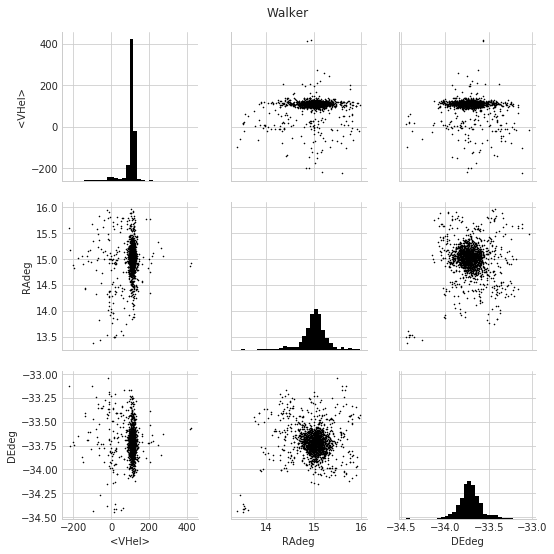

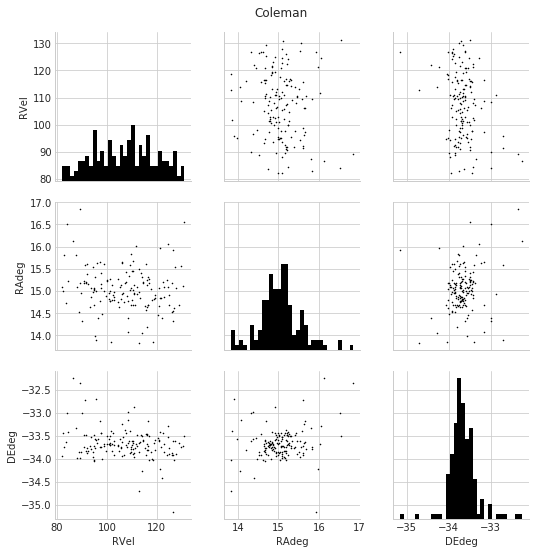

In [9]:
import seaborn as sns
sns.set_style("whitegrid")

ax = sns.pairplot(
    df_walker[["<VHel>","RAdeg","DEdeg"]],markers=".",
    diag_kws={"bins":32,"color":"black"},
    plot_kws={"s":10,"linewidths":0,"color":"black"})
plt.suptitle("Walker",y=1.02)

sns.pairplot(
    df_colman[["RVel","RAdeg","DEdeg"]],markers=".",
    diag_kws={"bins":32,"color":"black"},
    plot_kws={"s":10,"linewidths":0,"color":"black"})
plt.suptitle("Coleman",y=1.02)

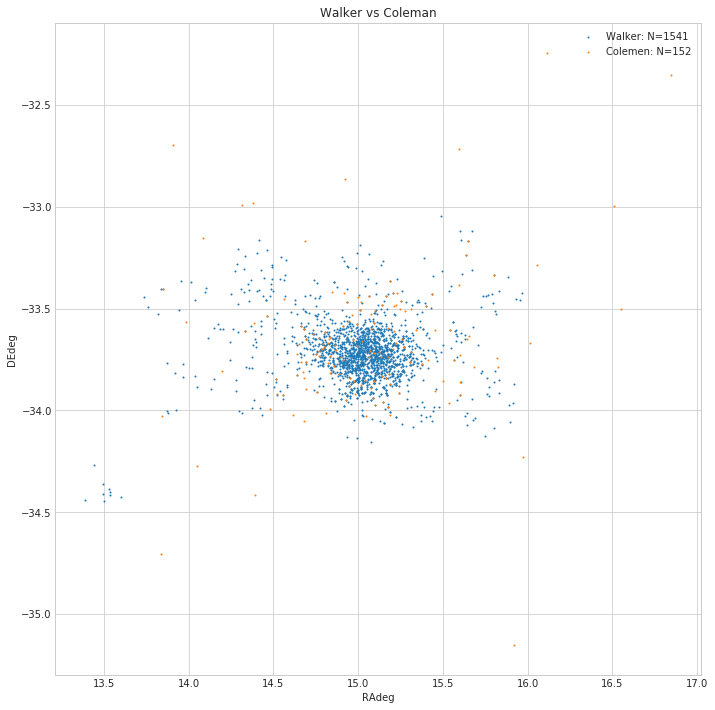

In [10]:
ax = df_walker_raw.plot.scatter("RAdeg","DEdeg",s=1,figsize=(12,12))
df_colman.plot.scatter("RAdeg","DEdeg",s=1,c="C1",ax=ax)

ax.set_aspect(1/np.cos(df_walker.DEdeg.mean()*(np.pi/180)))
ax.set_title("Walker vs Coleman")
plt.legend(["Walker: N={}".format(len(df_walker)),"Colemen: N={}".format(len(df_colman))])

plt.show()
#print(1/np.cos(df_walker.DEdeg.mean()*(np.pi/180)))

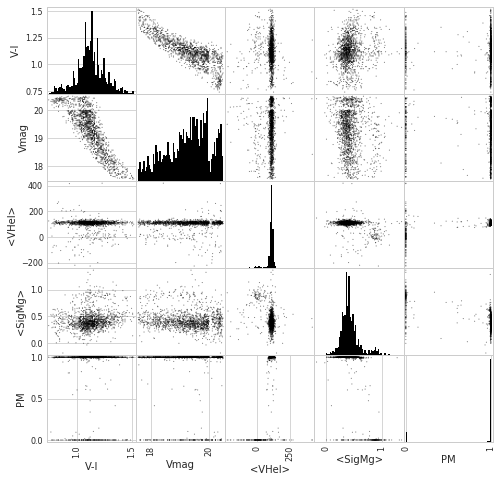

In [11]:
pd.plotting.scatter_matrix(
    df_walker[["V-I","Vmag","<VHel>","<SigMg>","PM"]],s=5,figsize=(8,8),c="black",
    hist_kwds={"bins":64,"color":"black"})
plt.show()

## DES

COADD_OBJECT_ID            RAP           DECP          PSF_G  \
count     3.356430e+05  335643.000000  335643.000000  335643.000000   
mean      2.896426e+08      15.017855     -33.789155      67.548483   
std       3.293602e+06       0.509347       0.495442      37.498088   
min       2.836375e+08      14.000012     -34.799994      13.924475   
25%       2.885675e+08      14.659025     -34.137138      23.360105   
50%       2.891215e+08      15.018558     -33.753220      98.923538   
75%       2.908955e+08      15.389927     -33.468088      98.942368   
max       3.017892e+08      15.999977     -32.800003      98.956223   

               PSF_R          PSF_I          PSF_Z          PSF_Y  \
count  335643.000000  335643.000000  335643.000000  335643.000000   
mean       51.481929      60.611191      72.323440      86.292992   
std        37.011430      38.474050      36.876453      28.976292   
min        14.251953      14.554042      14.427052      11.962654   
25%        22.816422      22.474919      22.173324      98.974136   
50%        23.563673      98.943596      98.975349      98.980049   
75%        98.956924      98.971146      98.978699      98.981819   
max        98.970596      98.978439      98.983566      98.985603   

            PSFERR_G       PSFERR_R       PSFERR_I       PSFERR_Z  \
count  335643.000000  335643.000000  335643.000000  335643.000000   
mean       58.231479      37.453644      49.670954      65.042262   
std        48.693022      47.963475      49.464682      46.973179   
min         0.000099       0.000182       0.000095       0.000383   
25%         0.078950       0.050691       0.056631       0.088015   
50%        99.000000       0.127594      99.000000      99.000000   
75%        99.000000      99.000000      99.000000      99.000000   
max        99.000000      99.000000      99.000000      99.000000   

            PSFERR_Y  SPREAD_MODEL_G  SPREAD_MODEL_R  SPREAD_MODEL_I  \
count  335643.000000    3.356430e+05   335643.000000   335643.000000   
mean       83.081195   -8.871119e+01       -0.020698       -0.159964   
std        36.352562    5.065796e+04       11.994395       81.182002   
min         0.000254   -2.934674e+07    -6564.790039   -38153.730469   
25%        99.000000   -3.017227e-03       -0.001104       -0.001632   
50%        99.000000    2.436249e-03        0.004884        0.005165   
75%        99.000000    9.336156e-03        0.012087        0.012791   
max        99.000000    2.612673e+04      390.537079    10618.072266   

       SPREAD_MODEL_Z  SPREAD_MODEL_Y  
count   335643.000000    3.356430e+05  
mean        -0.803028    3.073494e+02  
std        481.595208    1.910274e+05  
min    -242199.031250   -1.753442e+06  
25%         -0.002492   -1.523518e-02  
50%          0.004346   -1.405157e-03  
75%          0.012143    8.281269e-03  
max      90081.406250    1.106449e+08

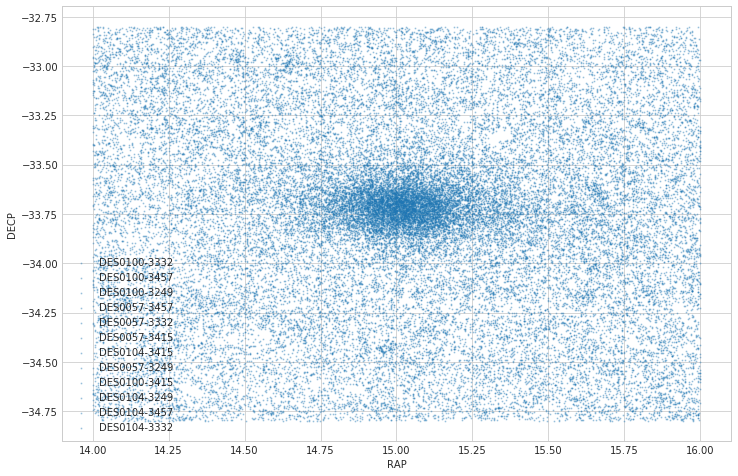

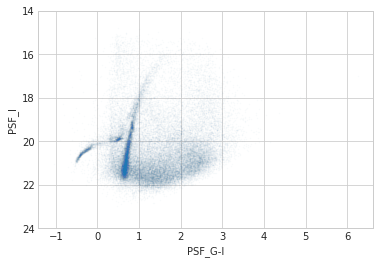

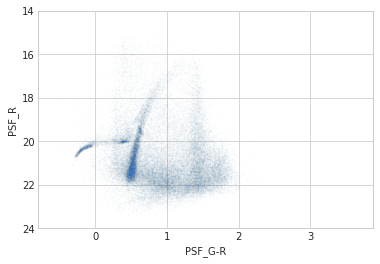

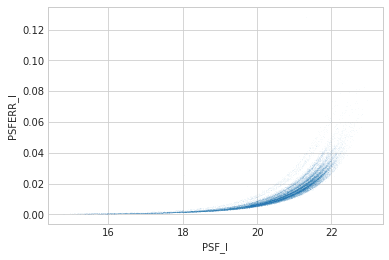

In [12]:
df_des=pd.read_csv("data/des20181221.csv",comment="#")

display(df_des.describe())

#df_des_photometry = df_des[(df_des.PSF_I<50) & (df_des.PSF_G<50)]
PSF_bands = ["PSF_"+band for band in "GRIZY"]
spread_models = ["SPREAD_MODEL_"+band for band in "GRIZY"]

df_des_photometry = df_des[np.prod([df_des[band]<50 for band in PSF_bands],axis=0,dtype=bool)].copy()
df_des_photometry = df_des_photometry[np.prod([np.abs(df_des_photometry[spread_mdl])<0.1 for spread_mdl in spread_models],axis=0,dtype=bool)].copy() # only stars, not galaxies
df_des_photometry["PSF_G-I"] = df_des_photometry.PSF_G - df_des_photometry.PSF_I
df_des_photometry["PSF_G-R"] = df_des_photometry.PSF_G - df_des_photometry.PSF_R

fig,ax = plt.subplots(1,1,figsize=(12,8))
cmap = plt.get_cmap("tab10")
for i,tilename in enumerate(df_des.TILENAME.unique()):
    #df_des_photometry[df_des_photometry.TILENAME==tilename].plot.scatter("RAP","DECP",alpha=0.3,s=1,ax=ax,c=cmap(i),label=tilename)
    df_des_photometry[df_des_photometry.TILENAME==tilename].plot.scatter("RAP","DECP",alpha=0.3,s=1,ax=ax,c="C0",label=tilename)
#plt.legend()
plt.show()

df_des_photometry.plot.scatter("PSF_G-I","PSF_I",alpha=0.05,s=0.05)
plt.ylim([24,14])
plt.show()

df_des_photometry.plot.scatter("PSF_G-R","PSF_R",alpha=0.05,s=0.05)
plt.ylim([24,14])
plt.show()

df_des_photometry.plot.scatter("PSF_I","PSFERR_I",alpha=0.1,s=0.01)
plt.show()

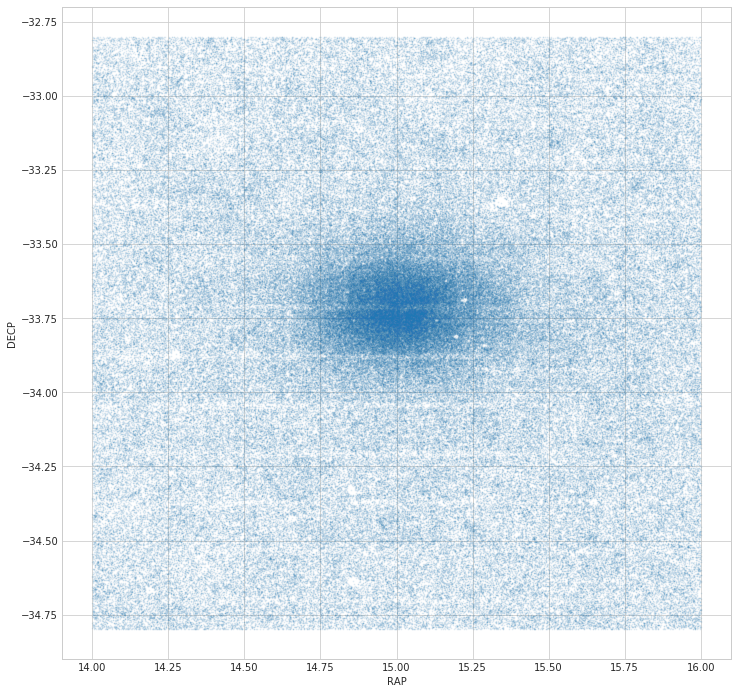

In [13]:
df_des.plot.scatter("RAP","DECP",s=0.5,alpha=0.1,figsize=(12,12))

COADD_OBJECT_ID            RAP           DECP          PSF_G  \
count     3.356430e+05  335643.000000  335643.000000  335643.000000   
mean      2.896426e+08      15.017855     -33.789155      67.548483   
std       3.293602e+06       0.509347       0.495442      37.498088   
min       2.836375e+08      14.000012     -34.799994      13.924475   
25%       2.885675e+08      14.659025     -34.137138      23.360105   
50%       2.891215e+08      15.018558     -33.753220      98.923538   
75%       2.908955e+08      15.389927     -33.468088      98.942368   
max       3.017892e+08      15.999977     -32.800003      98.956223   

               PSF_R          PSF_I          PSF_Z          PSF_Y  \
count  335643.000000  335643.000000  335643.000000  335643.000000   
mean       51.481929      60.611191      72.323440      86.292992   
std        37.011430      38.474050      36.876453      28.976292   
min        14.251953      14.554042      14.427052      11.962654   
25%        22.816422      22.474919      22.173324      98.974136   
50%        23.563673      98.943596      98.975349      98.980049   
75%        98.956924      98.971146      98.978699      98.981819   
max        98.970596      98.978439      98.983566      98.985603   

            PSFERR_G       PSFERR_R       PSFERR_I       PSFERR_Z  \
count  335643.000000  335643.000000  335643.000000  335643.000000   
mean       58.231479      37.453644      49.670954      65.042262   
std        48.693022      47.963475      49.464682      46.973179   
min         0.000099       0.000182       0.000095       0.000383   
25%         0.078950       0.050691       0.056631       0.088015   
50%        99.000000       0.127594      99.000000      99.000000   
75%        99.000000      99.000000      99.000000      99.000000   
max        99.000000      99.000000      99.000000      99.000000   

            PSFERR_Y  SPREAD_MODEL_G  SPREAD_MODEL_R  SPREAD_MODEL_I  \
count  335643.000000    3.356430e+05   335643.000000   335643.000000   
mean       83.081195   -8.871119e+01       -0.020698       -0.159964   
std        36.352562    5.065796e+04       11.994395       81.182002   
min         0.000254   -2.934674e+07    -6564.790039   -38153.730469   
25%        99.000000   -3.017227e-03       -0.001104       -0.001632   
50%        99.000000    2.436249e-03        0.004884        0.005165   
75%        99.000000    9.336156e-03        0.012087        0.012791   
max        99.000000    2.612673e+04      390.537079    10618.072266   

       SPREAD_MODEL_Z  SPREAD_MODEL_Y  
count   335643.000000    3.356430e+05  
mean        -0.803028    3.073494e+02  
std        481.595208    1.910274e+05  
min    -242199.031250   -1.753442e+06  
25%         -0.002492   -1.523518e-02  
50%          0.004346   -1.405157e-03  
75%          0.012143    8.281269e-03  
max      90081.406250    1.106449e+08

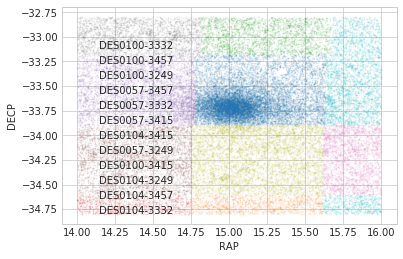

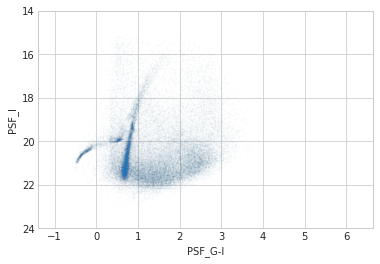

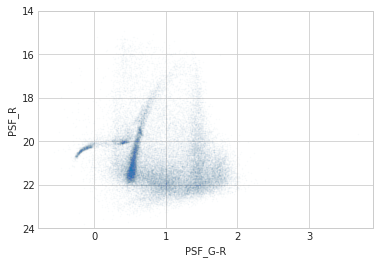

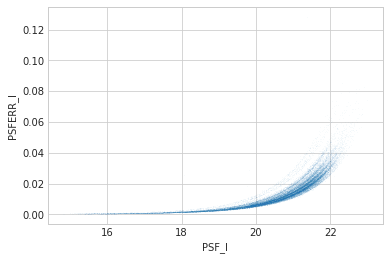

In [14]:
df_des_redden=pd.read_csv("data/des20181218.csv",comment="#")

display(df_des.describe())

#df_des_photometry = df_des[(df_des.PSF_I<50) & (df_des.PSF_G<50)]
PSF_bands = ["PSF_"+band for band in "GRIZY"]
spread_models = ["SPREAD_MODEL_"+band for band in "GRIZY"]

df_des_redden_photometry = df_des_redden[np.prod([df_des_redden[band]<50 for band in PSF_bands],axis=0,dtype=bool)].copy()
df_des_redden_photometry = df_des_redden_photometry[np.prod([np.abs(df_des_redden_photometry[spread_mdl])<0.1 for spread_mdl in spread_models],axis=0,dtype=bool)].copy() # only stars, not galaxies
df_des_redden_photometry["PSF_G-I"] = df_des_redden_photometry.PSF_G - df_des_redden_photometry.PSF_I
df_des_redden_photometry["PSF_G-R"] = df_des_redden_photometry.PSF_G - df_des_redden_photometry.PSF_R

fig,ax = plt.subplots(1,1)
cmap = plt.get_cmap("tab10")
for i,tilename in enumerate(df_des.TILENAME.unique()):
    df_des_redden_photometry[df_des_redden_photometry.TILENAME==tilename].plot.scatter("RAP","DECP",alpha=0.1,s=0.5,ax=ax,c=cmap(i),label=tilename)
#plt.legend()
plt.show()

df_des_redden_photometry.plot.scatter("PSF_G-I","PSF_I",alpha=0.05,s=0.05)
plt.ylim([24,14])
plt.show()

df_des_redden_photometry.plot.scatter("PSF_G-R","PSF_R",alpha=0.05,s=0.05)
plt.ylim([24,14])
plt.show()

df_des_redden_photometry.plot.scatter("PSF_I","PSFERR_I",alpha=0.1,s=0.01)
plt.show()

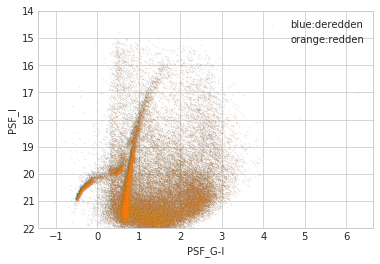

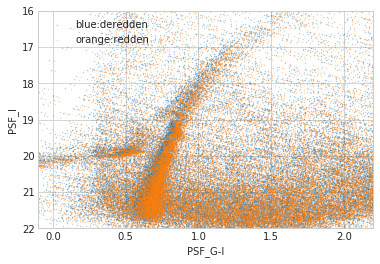

In [15]:
fig,ax = plt.subplots(1,1)
df_des_photometry.plot.scatter("PSF_G-I","PSF_I",s=0.01,ax=ax,alpha=0.5)
df_des_redden_photometry.plot.scatter("PSF_G-I","PSF_I",s=0.01,ax=ax,c="C1",alpha=0.5)
plt.ylim([22,14])
plt.legend(["blue:deredden","orange:redden"])
plt.show()

fig,ax = plt.subplots(1,1)
df_des_photometry.plot.scatter("PSF_G-I","PSF_I",s=0.1,ax=ax,alpha=0.5)
df_des_redden_photometry.plot.scatter("PSF_G-I","PSF_I",s=0.1,ax=ax,c="C1",alpha=0.5)
plt.xlim([-0.1,2.2])
plt.ylim([22,16])
plt.legend(["blue:deredden","orange:redden"])
plt.show()

In [16]:
np.unique(np.unique(df_des_photometry.COADD_OBJECT_ID,return_counts=True)[1],return_counts=True)

(array([1]), array([43299]))

In [17]:
df_des_photometry.describe()

COADD_OBJECT_ID           RAP          DECP         PSF_G  \
count     4.329900e+04  43299.000000  43299.000000  43299.000000   
mean      2.896431e+08     15.026191    -33.770823     21.672235   
std       3.303015e+06      0.512737      0.502501      1.471407   
min       2.836380e+08     14.000183    -34.799977     15.185178   
25%       2.885704e+08     14.660468    -34.126770     20.749214   
50%       2.908136e+08     15.029041    -33.734300     21.927715   
75%       2.908958e+08     15.408639    -33.442266     22.808400   
max       3.017892e+08     15.999977    -32.800010     24.386917   

              PSF_R         PSF_I         PSF_Z         PSF_Y      PSFERR_G  \
count  43299.000000  43299.000000  43299.000000  43299.000000  43299.000000   
mean      20.772373     20.378771     20.172116     20.033035      0.032997   
std        1.313421      1.298706      1.309391      1.259396      0.036024   
min       14.873588     14.780601     14.599002     14.511557      0.000297   
25%       20.130417     19.835128     19.639075     19.538276      0.008243   
50%       21.094522     20.709721     20.508261     20.401417      0.020426   
75%       21.693542     21.310322     21.114488     20.944317      0.043708   
max       23.740744     22.969660     22.708849     22.067642      0.310346   

           PSFERR_R      PSFERR_I      PSFERR_Z      PSFERR_Y  SPREAD_MODEL_G  \
count  43299.000000  43299.000000  43299.000000  43299.000000    43299.000000   
mean       0.013751      0.013597      0.018435      0.058119        0.006943   
std        0.010833      0.009963      0.014089      0.049233        0.009048   
min        0.000310      0.000095      0.000383      0.000511       -0.025032   
25%        0.005618      0.005806      0.007419      0.020039       -0.000205   
50%        0.011467      0.011705      0.015689      0.044125        0.004112   
75%        0.019054      0.019498      0.026924      0.082861        0.013551   
max        0.177687      0.128078      0.298173      0.428869        0.044044   

       SPREAD_MODEL_R  SPREAD_MODEL_I  SPREAD_MODEL_Z  SPREAD_MODEL_Y  \
count    43299.000000    43299.000000    43299.000000    43299.000000   
mean         0.008476        0.008394        0.008338        0.007500   
std          0.009865        0.010219        0.009522        0.009127   
min         -0.014464       -0.013879       -0.011294       -0.022626   
25%         -0.000060       -0.000603       -0.000144       -0.000147   
50%          0.007113        0.006454        0.006216        0.005063   
75%          0.016054        0.016531        0.016022        0.014628   
max          0.041904        0.041885        0.042190        0.065756   

            PSF_G-I       PSF_G-R  
count  43299.000000  43299.000000  
mean       1.293464      0.899862  
std        0.792761      0.484049  
min       -1.053368     -0.584854  
25%        0.687982      0.523655  
50%        1.150036      0.846594  
75%        1.899346      1.331699  
max        6.254831      3.662909

SPREAD_MODEL_G  SPREAD_MODEL_R  SPREAD_MODEL_I  SPREAD_MODEL_Z  \
count    43299.000000    43299.000000    43299.000000    43299.000000   
mean         0.006943        0.008476        0.008394        0.008338   
std          0.009048        0.009865        0.010219        0.009522   
min         -0.025032       -0.014464       -0.013879       -0.011294   
25%         -0.000205       -0.000060       -0.000603       -0.000144   
50%          0.004112        0.007113        0.006454        0.006216   
75%          0.013551        0.016054        0.016531        0.016022   
max          0.044044        0.041904        0.041885        0.042190   

       SPREAD_MODEL_Y  
count    43299.000000  
mean         0.007500  
std          0.009127  
min         -0.022626  
25%         -0.000147  
50%          0.005063  
75%          0.014628  
max          0.065756

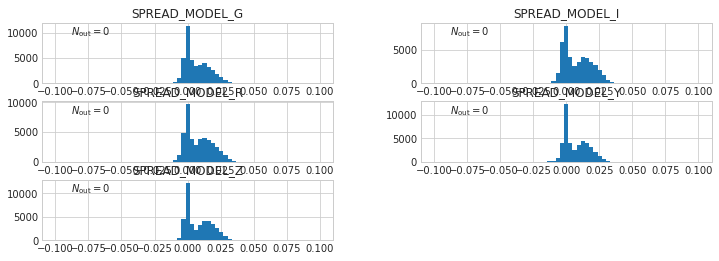

Index(['TILENAME', 'COADD_OBJECT_ID', 'RAP', 'DECP', 'PSF_G', 'PSF_R', 'PSF_I',
       'PSF_Z', 'PSF_Y', 'PSFERR_G', 'PSFERR_R', 'PSFERR_I', 'PSFERR_Z',
       'PSFERR_Y', 'SPREAD_MODEL_G', 'SPREAD_MODEL_R', 'SPREAD_MODEL_I',
       'SPREAD_MODEL_Z', 'SPREAD_MODEL_Y'],
      dtype='object')

In [18]:
bins = np.linspace(-0.1,0.1,64)
spread_models = ["SPREAD_MODEL_G","SPREAD_MODEL_R","SPREAD_MODEL_I","SPREAD_MODEL_Z","SPREAD_MODEL_Y"]
display(df_des_photometry[spread_models].describe())
axes = df_des_photometry[spread_models].hist(bins=bins,figsize=(12,4))
leds = ["{}:$N_\\mathrm{}={}$".format(model,"{out}",(np.abs(df_des_photometry[model])>0.1).sum()) for model in spread_models]
[ax.text(
    s="$N_\\mathrm{}={}$".format("{out}",(np.abs(df_des_photometry[ax.title.get_text()])>0.1).sum()),
    x=0.1,y=0.8,transform=ax.transAxes
) if ax.title.get_text() != "" else None for ax in axes.flatten()]
plt.show()
display(df_des.columns)

In [19]:
#sns.pairplot(df_des[spread_models])

In [20]:
#df_des.TILENAME

## Becsancon

Index(['Dist', 'Mv', 'CL', 'Typ', 'LTef', 'logg', 'Age', 'Mass', 'B-V', 'U-B',
       'V-I', 'V-K', 'V', 'mux', 'muy', 'Vr', 'UU', 'VV', 'WW', '[Fe/H]',
       'a(deg)', 'd(deg)', 'Av', 'Mbol', 'V-I_Walker', 'V_Walker'],
      dtype='object')

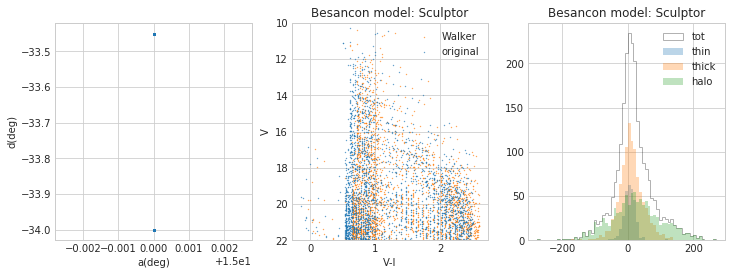

In [254]:
# Becanson model
fig,axes = plt.subplots(1,3,figsize=(12,4))

df_bes = pd.read_csv("data/1545029094.511467.resu.txt",comment="#",delim_whitespace=True)
df_bes["V-I_Walker"] = df_bes["V-I"] - dVmI
df_bes["V_Walker"] = df_bes["V"] - dV
display(df_bes.columns)

df_bes.plot.scatter("a(deg)","d(deg)",s=1,ax=axes[0])

df_bes.plot.scatter("V-I_Walker","V_Walker",s=0.1,ax=axes[1],label="Walker",c="C1")
df_bes.plot.scatter("V-I","V",s=0.1,ax=axes[1],label="original",c="C0")
plt.plot()

axes[1].legend()
axes[1].set_ylim(22,10)
axes[1].set_title("Besancon model: Sculptor")
#plt.show()
bins = np.linspace(df_bes.Vr.min(),df_bes.Vr.max(),64)
df_bes_halo  = df_bes[(-99 < df_bes["[Fe/H]"]) & (df_bes["[Fe/H]"] <= -1.0)]
df_bes_thick = df_bes[(-1.0 < df_bes["[Fe/H]"]) & (df_bes["[Fe/H]"] <= -0.1)]
df_bes_thin  = df_bes[(-0.1 < df_bes["[Fe/H]"]) & (df_bes["[Fe/H]"] <= +99)]
df_bes.Vr.hist(histtype='step',bins=bins,alpha=0.3,color="black",ax=axes[2])
df_bes_thin.Vr.hist(bins=bins,alpha=0.3,color="C0",ax=axes[2])
df_bes_thick.Vr.hist(bins=bins,alpha=0.3,color="C1",ax=axes[2])
df_bes_halo.Vr.hist(bins=bins,alpha=0.3,color="C2",ax=axes[2])
axes[2].legend(["tot","thin","thick","halo"])
axes[2].set_title("Besancon model: Sculptor")
plt.show()

#df_bes["a(deg)"]

# CMD cut
## conversion

In [22]:
# des -> sdss -> Johnson, redden
sdss_from_des_redden  = des_to_sdss_DR1(
    g_des=df_des_redden_photometry.PSF_G,    
    r_des=df_des_redden_photometry.PSF_R,
    i_des=df_des_redden_photometry.PSF_I,
    z_des=df_des_redden_photometry.PSF_Z)
#display(sdss_from_des_redden)
for name,key in zip([band+"_SDSS" for band in "GRIZ"],[band+"_sdss" for band in "griz"]):
    df_des_redden_photometry[name] = sdss_from_des_redden[key]
df_des_redden_photometry["VALID_des_to_sdss"] = sdss_from_des_redden["VALID"]

johnson_redden = sdss_to_Johnson(
    u_sdss=np.nan,
    g_sdss=df_des_redden_photometry["G_SDSS"],
    r_sdss=df_des_redden_photometry["R_SDSS"],
    i_sdss=df_des_redden_photometry["I_SDSS"],
    z_sdss=df_des_redden_photometry["Z_SDSS"],
    table="Jester2005")
johnson = pd.DataFrame(johnson_redden)
johnson_redden
#for key in johnson.keys():
#    df_des_photometry["Johnson_"+key] = johnson[key]
df_des_redden_photometry["Johnson_V-I"] = johnson_redden["V_Johnson"] - johnson_redden["I_Johnson"]
df_des_redden_photometry["Johnson_I"] = johnson_redden["I_Johnson"]
df_des_redden_photometry["Johnson_V"] = johnson_redden["V_Johnson"]
#df_Johnson[np.abs(df_Johnson["I"])<50].plot.scatter("V-I","I",s=0.1,alpha=0.1)
#df_Johnson.plot.scatter("V-I","I",s=0.1,alpha=0.1)
is_trans_valid_redden = df_des_redden_photometry["VALID_des_to_sdss"]
is_trans_not_valid_redden = np.logical_not(is_trans_valid_redden)



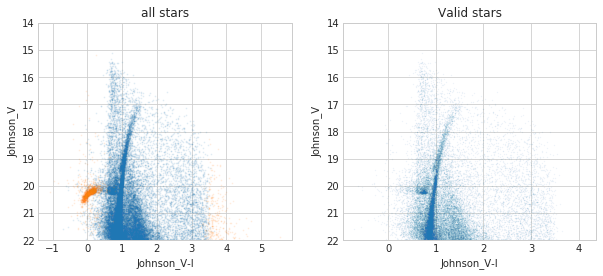

In [23]:
# show the result of conversion

fig,axes = plt.subplots(1,2,figsize=(10,4))
kwargs = {"s":0.5,"alpha":0.1,"ax":axes[0]}

np_not = np.logical_not
#valid_J = df_des_photometry.Johnson_VALID
valid_des = df_des_redden_photometry.VALID_des_to_sdss
#is_valid = valid_J & valid_des

#df_des_photometry.plot.scatter("Johnson_V-I","Johnson_I",**kwargs)
#df_des_photometry[valid_J & valid_des].plot.scatter("Johnson_V-I","Johnson_I",**kwargs)
df_des_redden_photometry[valid_des].plot.scatter("Johnson_V-I","Johnson_V",**kwargs)
#df_des_photometry[valid_J & lgc_not(valid_des)].plot.scatter("Johnson_V-I","Johnson_I",**kwargs,c="C1")
df_des_redden_photometry[np.logical_not(valid_des)].plot.scatter("Johnson_V-I","Johnson_V",**kwargs,c="C1")
#df_des_photometry[lgc_not(valid_J) & valid_des].plot.scatter("Johnson_V-I","Johnson_I",**kwargs,c="C2")
#df_des_photometry[lgc_not(valid_J) & lgc_not(valid_des)].plot.scatter("Johnson_V-I","Johnson_I",**kwargs,c="C3")
plt.ylim([22,14])
axes[0].set_title("all stars")
#axes[0].legend(["blue:valid","orange:invalid(des->sdss)","green:invalid(sdss->Johnson)","red:invalid(both)"])
axes[0].set_ylim([22,14])
#plt.show()

#df_des_photometry[valid_J & valid_des].plot.scatter("Johnson_V-I","Johnson_I",s=0.1,alpha=0.1,ax=axes[1])
df_des_redden_photometry[valid_des].plot.scatter("Johnson_V-I","Johnson_V",s=0.1,alpha=0.1,ax=axes[1])
axes[1].set_title("Valid stars")
axes[1].set_ylim([22,14])
plt.show()

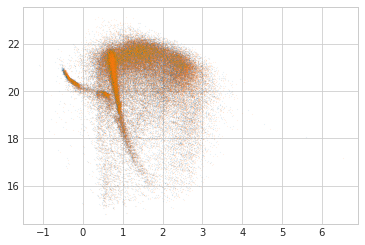

In [24]:
sdss_from_des_redden  = des_to_sdss_DR1(
    g_des=df_des_redden_photometry.PSF_G,    
    r_des=df_des_redden_photometry.PSF_R,
    i_des=df_des_redden_photometry.PSF_I,
    z_des=df_des_redden_photometry.PSF_Z)
sdss_from_des_redden_y1a1  = des_to_sdss_Y1A1(
    g_des=df_des_redden_photometry.PSF_G,    
    r_des=df_des_redden_photometry.PSF_R,
    i_des=df_des_redden_photometry.PSF_I,
    z_des=df_des_redden_photometry.PSF_Z,
    y_des=df_des_redden_photometry.PSF_Y)
plt.scatter(sdss_from_des_redden["g_sdss"]-sdss_from_des_redden["i_sdss"],sdss_from_des_redden["i_sdss"],s=0.001,label="DR1")
plt.scatter(sdss_from_des_redden_y1a1["g_sdss"]-sdss_from_des_redden_y1a1["i_sdss"],sdss_from_des_redden_y1a1["i_sdss"],s=0.001,label="Y1A1")
plt.show()

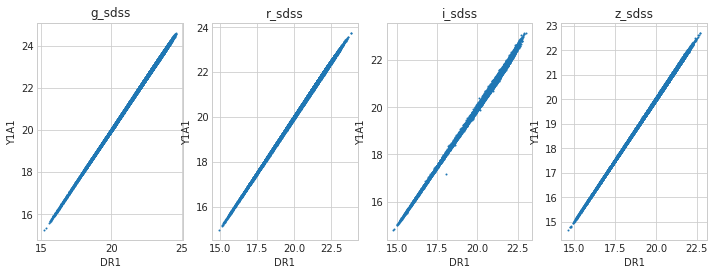

In [25]:
fig,axes = plt.subplots(1,4,figsize=(12,4))
for i,band in enumerate([s+"_sdss" for s in "griz"]):
    axes[i].scatter(sdss_from_des_redden[band],sdss_from_des_redden_y1a1[band],s=1)
    #plt.plot(x=[15,24],y=[15,24],c="C1")
    axes[i].set_title(band)
    axes[i].set_xlabel("DR1")
    axes[i].set_ylabel("Y1A1")
plt.show()
    

## cut

[[ 1.33007335  1.1002445   0.8997555   1.19990039  1.29894503  1.54514172]
 [17.58606557 18.48360656 19.98360656 19.98781876 18.75688752 17.49749545]]
[[ 1.1002445   0.8997555   1.19990039  1.29894503  1.54514172  1.33007335]
 [18.48360656 19.98360656 19.98781876 18.75688752 17.49749545 17.58606557]]


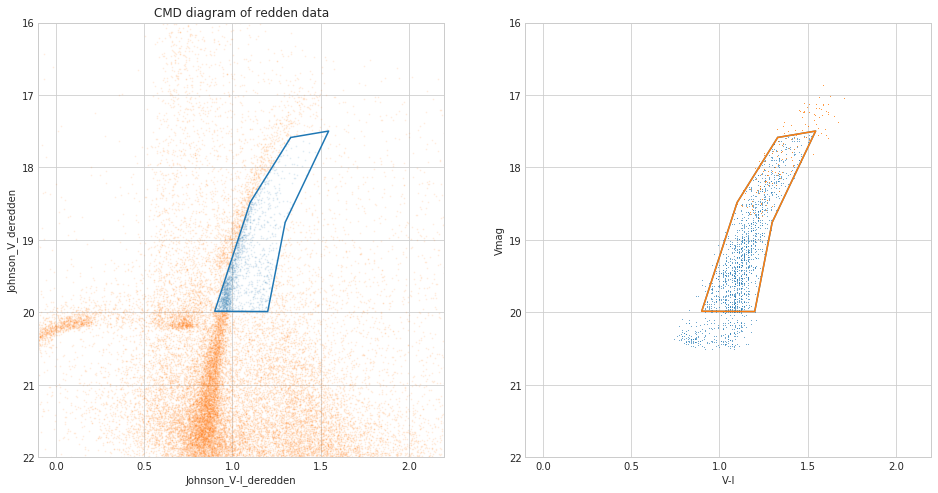

In [221]:
# redden

valid_des_redden = df_des_redden_photometry.VALID_des_to_sdss

df_des_redden_photometry["Johnson_V-I_deredden"] = df_des_redden_photometry["Johnson_V-I"] - 0.023 # deredden
df_des_redden_photometry["Johnson_V_deredden"] = df_des_redden_photometry["Johnson_V"] - 0.059 # brighter

import cmd_utilities
xs_vertex,ys_vertex = np.loadtxt("CMD_cut_Walker2007.csv",delimiter=",").T
xs_vertex,ys_vertex
poly_x,poly_y = np.append(xs_vertex,xs_vertex[0]),np.append(ys_vertex,ys_vertex[0])
inpoly_redden = cmd_utilities.inpoly(df_des_redden_photometry["Johnson_V-I_deredden"].values,df_des_redden_photometry["Johnson_V_deredden"].values,xs_vertex,ys_vertex)
fig,axes = plt.subplots(1,2,figsize=(16,8))
df_des_redden_photometry[inpoly_redden & valid_des_redden].plot.scatter("Johnson_V-I_deredden","Johnson_V_deredden",alpha=0.1,s=0.5,ax=axes[0])
df_des_redden_photometry[np.logical_not(inpoly_redden & valid_des_redden)].plot.scatter("Johnson_V-I_deredden","Johnson_V_deredden",alpha=0.1,s=0.5,c="C1",ax=axes[0])
axes[0].plot(np.append(xs_vertex,xs_vertex[0]),np.append(ys_vertex,ys_vertex[0]))
axes[0].set_title("CMD diagram of redden data")
axes[0].set_xlim([-0.1,2.2])
axes[0].set_ylim([22,16])

df_walker.plot.scatter("V-I","Vmag",s=0.5,linewidth=0,ax=axes[1])
axes[1].plot(poly_x,poly_y)
axes[1].set_xlim([-0.1,2.2])
axes[1].set_ylim([22,16])
#plt.show()

df_colman.plot.scatter("V-I","Vmag",s=1,linewidth=0,ax=axes[1],c="C1")
axes[1].plot(np.append(xs_vertex,xs_vertex[0]),np.append(ys_vertex,ys_vertex[0]))
axes[1].set_xlim([-0.1,2.2])
axes[1].set_ylim([22,16])
plt.show()

[[ 1.33007335  1.1002445   0.8997555   1.19990039  1.29894503  1.54514172]
 [17.58606557 18.48360656 19.98360656 19.98781876 18.75688752 17.49749545]]
[[ 1.1002445   0.8997555   1.19990039  1.29894503  1.54514172  1.33007335]
 [18.48360656 19.98360656 19.98781876 18.75688752 17.49749545 17.58606557]]


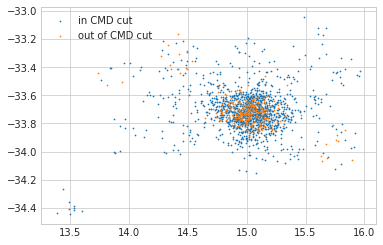

In [27]:
inpoly_spec = cmd_utilities.inpoly(df_walker["V-I"].values,df_walker["Vmag"].values,xs_vertex,ys_vertex)
plt.scatter(df_walker[inpoly_spec]["RAdeg"],df_walker[inpoly_spec]["DEdeg"],s=3,linewidths=0,label="in CMD cut")
plt.scatter(df_walker[np.logical_not(inpoly_spec)]["RAdeg"],df_walker[np.logical_not(inpoly_spec)]["DEdeg"],s=3,linewidths=0,label="out of CMD cut")
plt.legend()
plt.show()

In [29]:
display(df_walker[inpoly_spec])
display(df_walker[np.logical_not(inpoly_spec)])

Target Field       HJD  RAh  RAm    RAs DE-  DEd  DEm   DEs  \
0     Scl-0001   20B  3286.629    1    0  46.17   -   33   39  19.6   
2     Scl-0002   20B  3286.629    1    0  45.44   -   33   39  59.9   
4     Scl-0003   20B  3286.629    1    0  44.46   -   33   41  54.1   
6     Scl-0004   20B  3286.629    1    0  46.96   -   33   43  19.9   
9     Scl-0005   20B  3286.629    1    0  42.44   -   33   43  26.0   
13    Scl-0006   20B  3286.629    1    0  44.88   -   33   43  57.7   
15    Scl-0007   20B  3286.629    1    0  42.07   -   33   44   2.7   
16    Scl-0008   20B  3286.629    1    0  51.01   -   33   38  20.5   
18    Scl-0009   20B  3286.629    1    0  50.99   -   33   40   2.4   
20    Scl-0010   20B  3286.629    1    0  49.48   -   33   40  37.8   
22    Scl-0011   20B  3286.629    1    0  51.15   -   33   47  17.3   
24    Scl-0012   20B  3286.629    1    0  51.95   -   33   46  24.0   
27    Scl-0013   20B  3286.629    1    0  58.45   -   33   46  13.9   
30    Scl-0014   20B  3286.629    1    0  59.87   -   33   45  22.2   
31    Scl-0015   20B  3286.629    1    1   2.97   -   33   45  13.6   
32    Scl-0016   20B  3286.629    1    1   5.90   -   33   44  15.0   
33    Scl-0017   20B  3286.629    1    1   9.27   -   33   43  36.5   
35    Scl-0018   20B  3286.629    1    0  44.85   -   33   45  32.1   
37    Scl-0019   20B  3286.629    1    0  46.10   -   33   44  42.9   
39    Scl-0020   20B  3286.629    1    0  59.92   -   33   44  54.1   
40    Scl-0021   20B  3286.629    1    0  49.80   -   33   44  18.0   
41    Scl-0022   20B  3286.629    1    0  55.11   -   33   44  15.2   
43    Scl-0023   20B  3286.629    1    0  56.11   -   33   44   0.7   
45    Scl-0024   20B  3286.629    1    1   4.89   -   33   43  40.0   
46    Scl-0025   20B  3286.629    1    0  56.58   -   33   40  36.7   
48    Scl-0026   20B  3286.629    1    0  55.27   -   33   40  42.7   
50    Scl-0027   20B  3286.629    1    0  52.92   -   33   40  44.3   
51    Scl-0028   20B  3286.629    1    0  55.58   -   33   41   2.3   
54    Scl-0029   20B  3286.629    1    0  56.26   -   33   41  31.9   
56    Scl-0030   20B  3286.629    1    1   3.54   -   33   38  48.5   
...        ...   ...       ...  ...  ...    ...  ..  ...  ...   ...   
1777  Scl-1501    1R  4685.730    1    0  16.65   -   33   44   5.1   
1778  Scl-1502    1R  4685.730    1    0  20.17   -   33   39  44.6   
1779  Scl-1503    1R  4685.730    1    0  22.01   -   33   39  48.1   
1781  Scl-1505    1R  4685.730    1    0  21.38   -   33   43  29.8   
1783  Scl-1507    1R  4685.730    1    0  12.54   -   33   49   1.6   
1784  Scl-1508    1R  4685.730    1    0  19.77   -   33   46   3.0   
1785  Scl-1509    1R  4685.730    1    0  12.64   -   33   53   9.4   
1788  Scl-1512    1R  4685.730    1    0  13.63   -   33   46   2.9   
1789  Scl-1513    1R  4685.730    1    0  15.26   -   33   45  49.9   
1790  Scl-1514    1R  4685.730    1    0  26.56   -   33   36   5.3   
1791  Scl-1515    1R  4685.730    1    0  24.06   -   33   39  38.2   
1792  Scl-1516    1R  4685.730    1    0  22.57   -   33   40  44.9   
1793  Scl-1517    1R  4685.730    1    0  24.97   -   33   44   6.0   
1794  Scl-1518    1R  4685.730    1    0  32.53   -   33   36  54.0   
1796  Scl-1520    1R  4685.730    1    0  35.20   -   33   37  47.1   
1798  Scl-1522    1R  4685.730    1    0  38.02   -   33   41   5.2   
1799  Scl-1523    1R  4685.730    1    0  46.40   -   33   36  21.6   
1800  Scl-1524    1R  4685.730    1    0  45.05   -   33   38  35.8   
1801  Scl-1525    1R  4685.730    1    0  35.92   -   33   42  35.4   
1803  Scl-1527    1R  4685.730    1    0  47.95   -   33   42   8.2   
1805  Scl-1529    1R  4685.730    1    0  32.17   -   33   50   1.6   
1806  Scl-1530    1R  4685.730    1    0  33.05   -   33   48  40.2   
1808  Scl-1532  399B  4686.706    0   55  21.68   -   33   24   9.7   
1809  Scl-1533  399B  4686.706    0   55  23.45   -   33   24   9.9   
1810  Scl-1534  399B  4686.706  

Target Field       HJD  RAh  RAm    RAs DE-  DEd  DEm   DEs  \
132   Scl-0087   20B  3286.629    1    1  49.84   -   33   44  12.2   
164   Scl-0105   20R  3286.629    1    1   4.49   -   33   41  16.8   
197   Scl-0131    3B  3287.552    0   59   9.29   -   33   43  11.6   
214   Scl-0144    3B  3287.552    0   59  39.85   -   33   33  42.0   
268   Scl-0194    3B  3287.552    0   59  55.99   -   33   38   3.1   
394   Scl-0301   31B  3287.694    0   58  35.55   -   33   45  35.2   
406   Scl-0313   31B  3287.694    0   59   6.02   -   33   42  32.7   
467   Scl-0369    4B  3288.571    1    0  18.53   -   33   41  19.5   
488   Scl-0388    4B  3288.571    1    0  34.09   -   33   43  16.6   
522   Scl-0413    4B  3288.571    1    0  42.49   -   33   43  54.8   
686   Scl-0546    5B  3289.593    1    0   0.10   -   33   47  11.8   
786   Scl-0601    5B  3289.593    1    0  43.42   -   33   45  32.9   
800   Scl-0610    5B  3289.593    1    0  51.24   -   33   48  30.5   
973   Scl-0736   15B  3289.712    0   59  38.82   -   33   50  34.7   
1112  Scl-0846   45B  3663.763    1    0  36.69   -   33   27  54.2   
1164  Scl-0898   58B  3665.559    1    1  22.92   -   33   31  34.7   
1357  Scl-1089    1B  4354.749    1    0   1.77   -   33   43  12.2   
1358  Scl-1090    1B  4354.749    1    0   8.00   -   33   43  46.6   
1359  Scl-1091    1B  4354.749    1    0  18.85   -   33   44  43.9   
1360  Scl-1092    1B  4354.749    0   59  57.13   -   33   40   2.9   
1361  Scl-1093    1B  4354.749    0   59  50.45   -   33   48  41.7   
1362  Scl-1094    1B  4354.749    0   59  45.01   -   33   47   5.4   
1363  Scl-1095    1B  4354.749    0   59  46.28   -   33   43  10.1   
1364  Scl-1096    1B  4354.749    1    0  14.36   -   33   40  25.1   
1365  Scl-1097    1B  4354.749    1    0  20.41   -   33   43  32.6   
1366  Scl-1098    1B  4354.749    1    0  18.13   -   33   43  38.2   
1367  Scl-1099    1B  4354.749    1    0   1.82   -   33   43  57.2   
1369  Scl-1100    1B  4354.749    1    0  28.90   -   33   41  24.0   
1370  Scl-1101    1B  4354.749    1    0  37.31   -   33   39  30.7   
1371  Scl-1102    1B  4354.749    1    0  36.03   -   33   42  17.7   
...        ...   ...       ...  ...  ...    ...  ..  ...  ...   ...   
1730  Scl-1454    1B  4685.730    1    0  48.98   -   33   40  21.0   
1731  Scl-1455    1B  4685.730    1    1   8.29   -   33   39  11.6   
1732  Scl-1456    1B  4685.730    1    1   4.06   -   33   40  19.4   
1733  Scl-1457    1B  4685.730    1    0  54.85   -   33   42  13.1   
1734  Scl-1458    1B  4685.730    1    0  59.08   -   33   43  27.0   
1735  Scl-1459    1B  4685.730    1    1  14.85   -   33   48  58.6   
1736  Scl-1460    1B  4685.730    1    1   7.36   -   33   47   1.2   
1737  Scl-1461    1B  4685.730    1    1  15.41   -   33   46  45.1   
1738  Scl-1462    1B  4685.730    1    1  17.73   -   33   44  39.3   
1739  Scl-1463    1B  4685.730    1    0  37.23   -   33   53   9.3   
1740  Scl-1464    1B  4685.730    1    0  57.27   -   33   50  48.1   
1741  Scl-1465    1B  4685.730    1    0  51.80   -   33   50  32.0   
1742  Scl-1466    1B  4685.730    1    0  44.69   -   33   50   3.4   
1743  Scl-1467    1B  4685.730    1    1   1.04   -   33   47  10.3   
1744  Scl-1468    1B  4685.730    1    0  52.96   -   33   45  13.2   
1758  Scl-1482    1R  4685.730    1    0  16.15   -   33   37   8.6   
1767  Scl-1491    1R  4685.730    0   59  59.98   -   33   50  54.7   
1771  Scl-1495    1R  4685.730    0   59  44.16   -   33   45  25.1   
1773  Scl-1497    1R  4685.730    1    0   4.93   -   33   38  58.6   
1780  Scl-1504    1R  4685.730    1    0  15.53   -   33   42  36.9   
1782  Scl-1506    1R  4685.730    1    0  20.30   -   33   50  34.1   
1786  Scl-1510    1R  4685.730    1    0  11.25   -   33   49  26.6   
1787  Scl-1511    1R  4685.730    1    0  11.75   -   33   48  31.7   
1795  Scl-1519    1R  4685.730    1    0  34.10   -   33   37  15.6   
1797  Scl-1521    1R  4685.730  

(22, 16)

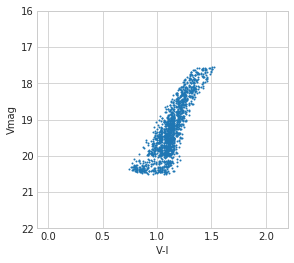

In [30]:
df_walker.plot.scatter("V-I","Vmag",s=1).set_aspect(1/3)
plt.xlim([-0.1,2.2])
plt.ylim([22,16])

In [244]:
df_des_redden_photometry.to_csv("data/des_photometry",index=None)

Text(0,0.5,'angular separation [arcsec]')

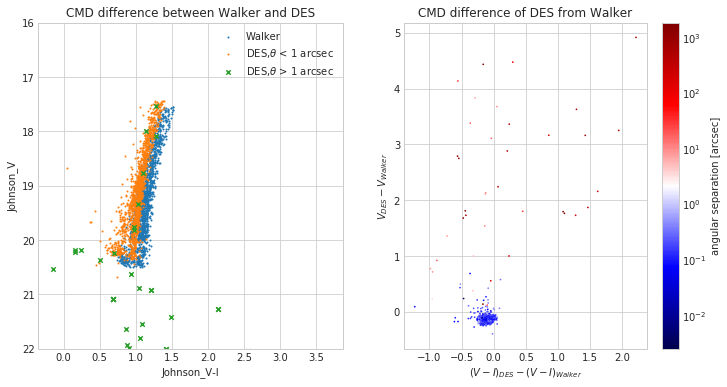

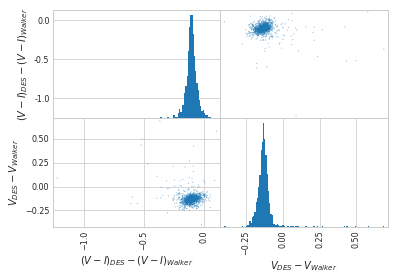

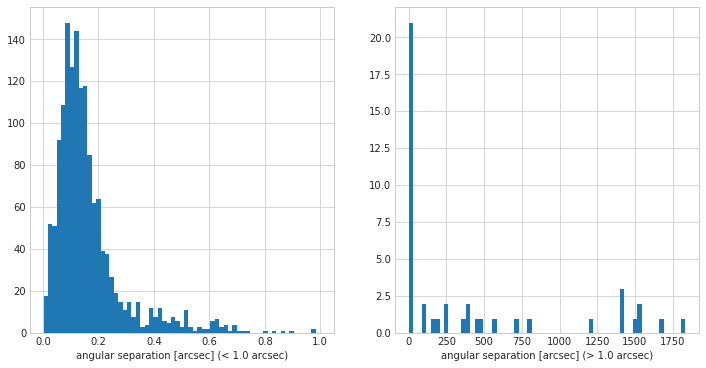

In [182]:
from astropy.units import deg
import matplotlib.cm as cm
from matplotlib import colors,colorbar

sc_des = SkyCoord(ra=df_des_redden_photometry.RAP.values*deg,dec=df_des_redden_photometry.DECP.values*deg)
sc_walker = SkyCoord(ra=df_walker.RAdeg.values*deg,dec=df_walker.DEdeg.values*deg)
idx,angles,_ = sc_walker.match_to_catalog_sky(sc_des)

fig,axes = plt.subplots(1,2,figsize=(12,6))
ax = axes[0]
df_walker.plot.scatter("V-I","Vmag",s=1,label="Walker",ax=ax)
df_des_redden_photometry.columns
df_des_redden_photometry.iloc[idx[angles.arcsec<=1]].plot.scatter("Johnson_V-I","Johnson_V",s=1,ax=ax,c="C1",label=r"DES,$\theta$ < 1 arcsec")
df_des_redden_photometry.iloc[idx[angles.arcsec>1]].plot.scatter("Johnson_V-I","Johnson_V",marker="x",ax=ax,c="C2",label=r"DES,$\theta$ > 1 arcsec")
ax.set_ylim([22,16])
ax.legend()
ax.set_title("CMD difference between Walker and DES")

df_diff = pd.DataFrame()
df_diff["$(V-I)_{DES}-(V-I)_{Walker}$"] = df_des_redden_photometry.iloc[idx]["Johnson_V-I"].values-df_walker["V-I"].values
df_diff["$V_{DES}-V_{Walker}$"] = df_des_redden_photometry.iloc[idx]["Johnson_V"].values-df_walker["Vmag"].values
df_diff["angles"] = angles.arcsec
#display(df_diff)
#df_diff[df_diff.angles<=1].plot.scatter("$(V-I)_{DES}-(V-I)_{Walker}$","$V_{DES}-V_{Walker}$",ax=axes[1],s=0.5,label=r"$\theta$ < 1 arcsec")
#df_diff[df_diff.angles>1].plot.scatter("$(V-I)_{DES}-(V-I)_{Walker}$","$V_{DES}-V_{Walker}$",ax=axes[1],s=0.5,label=r"$\theta$ > 1 arcsec",c="C1")
cm = df_diff.plot.scatter(
    "$(V-I)_{DES}-(V-I)_{Walker}$","$V_{DES}-V_{Walker}$",
    ax=axes[1],s=0.5,
    c="angles",cmap=cm.seismic,
    norm=colors.LogNorm(vmin=angles.arcsec.min(), vmax=angles.arcsec.max())
)
display(fig.axes[2].set_ylabel(r"angular separation [arcsec]"))

#axes[1].colorbar(pcm, extend='max')
axes[1].set_title("CMD difference of DES from Walker")
plt.show()

pd.plotting.scatter_matrix(
    df_diff[df_diff.angles<=1][["$(V-I)_{DES}-(V-I)_{Walker}$","$V_{DES}-V_{Walker}$"]],
    s=5,hist_kwds = {"bins":128}
)
#plt.legend()
#plt.title("CMD difference of DES from Walker")
plt.show()

#display([angles.deg.min(),angles.deg.max()])
fig,axes = plt.subplots(1,2,figsize=(12,6))
axes[0].hist(angles.arcsec,bins=np.linspace(angles.arcsec.min(),1,64))
axes[0].set_xlabel("angular separation [arcsec] (< 1.0 arcsec)")
axes[1].hist(angles.arcsec,bins=np.linspace(1,angles.arcsec.max(),64))
axes[1].set_xlabel("angular separation [arcsec] (> 1.0 arcsec)")
plt.show()

In [269]:
diff_res = df_diff[df_diff.angles<1][["$(V-I)_{DES}-(V-I)_{Walker}$","$V_{DES}-V_{Walker}$"]].describe(percentiles=[norm.cdf(x) for x in (-2,-1,0,1,2)])
diff_res.to_csv("data/DES-Walker.csv")
#df_diff[df_diff.angles<1][["$(V-I)_{DES}-(V-I)_{Walker}$","$V_{DES}-V_{Walker}$"]].describe().to_csv("")

In [243]:
display([poly_x,poly_y])
poly_x_v2,poly_y_v2 = poly_x.copy(),poly_y.copy()
poly_x_v2[2],poly_y_v2[2] = [0.70,20.5]
poly_x_v2[3],poly_y_v2[3] = [1.17,20.5]
np.savetxt(X=np.array([poly_x_v2,poly_y_v2]).T,fname="CMD_cut_ours.csv",delimiter=",")

[array([1.33007335, 1.1002445 , 0.8997555 , 1.19990039, 1.29894503,
        1.54514172, 1.33007335]),
 array([17.58606557, 18.48360656, 19.98360656, 19.98781876, 18.75688752,
        17.49749545, 17.58606557])]

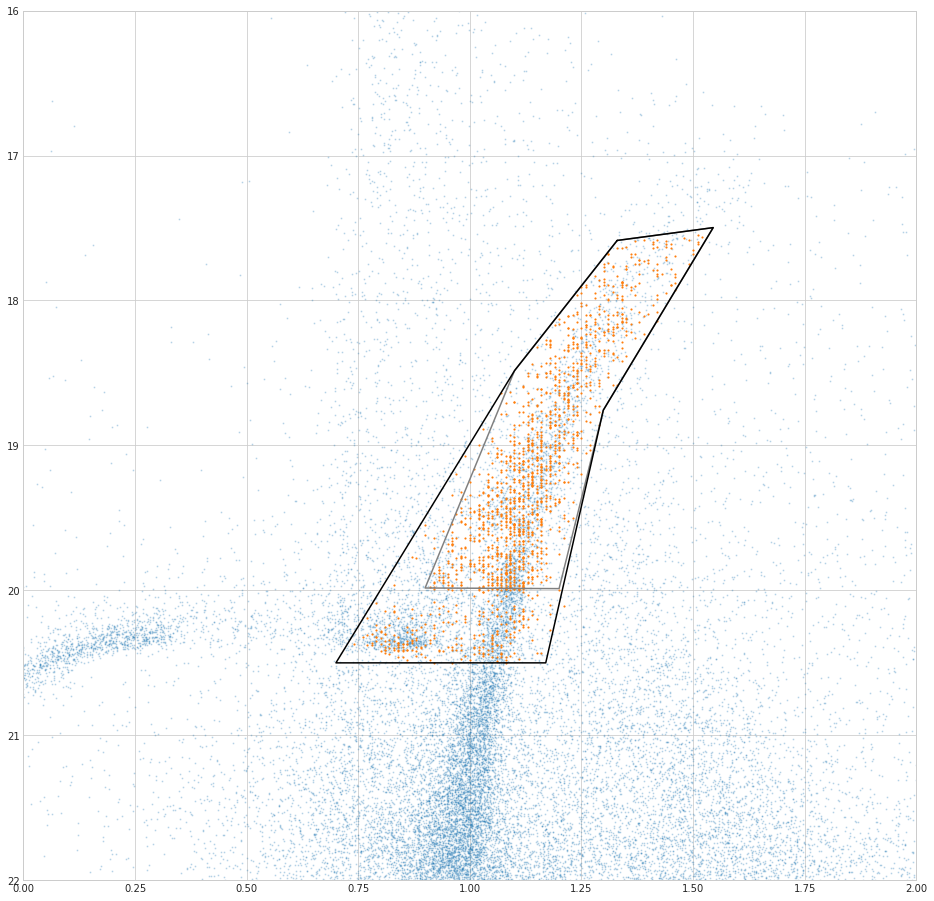

In [241]:
dVmI = df_diff[df_diff.angles<1]["$(V-I)_{DES}-(V-I)_{Walker}$"].mean()
dV = df_diff[df_diff.angles<1]["$V_{DES}-V_{Walker}$"].mean()

plt.figure(figsize=(16,16))
plt.scatter(df_des_redden_photometry["Johnson_V-I"]-dVmI,df_des_redden_photometry["Johnson_V"]-dV,s=1,alpha=0.2)
plt.scatter(df_walker["V-I"],df_walker["Vmag"],s=5,alpha=1,marker=".")
plt.plot(poly_x,poly_y,c="gray")
plt.plot(poly_x_v2,poly_y_v2,c="black")
plt.ylim([22,16])
plt.xlim([0,2])
plt.show()

In [246]:
df_des_redden_photometry["Walker_V-I"] = df_des_redden_photometry["Johnson_V-I"]-dVmI
df_des_redden_photometry["Walker_V"] = df_des_redden_photometry["Johnson_V"]-dV
df_des_redden_photometry.to_csv("data/des_photometry.csv",index=None)

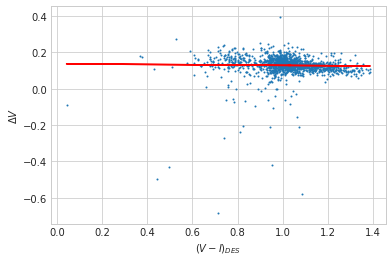

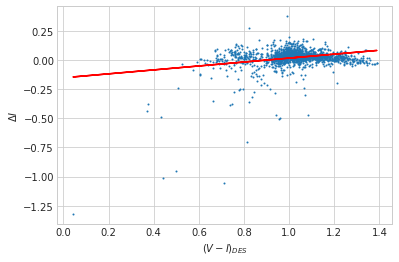

In [105]:
# Coleman-like fit
from sklearn.linear_model import LinearRegression
lr_dv,lr_di = LinearRegression(),LinearRegression()
df_walker_fit = df_walker[angles.arcsec<1.0]
df_des_fit = df_des_redden_photometry.iloc[idx[angles.arcsec<1.0]]

delta_v = (df_walker_fit["Vmag"].values - df_des_fit["Johnson_V"].values)
delta_i = (df_walker_fit["Vmag"].values-df_walker_fit["V-I"].values - df_des_fit["Johnson_I"].values)
vmi = df_des_fit["Johnson_V-I"].values

lr_dv.fit(vmi.reshape(-1,1),delta_v)
lr_di.fit(vmi.reshape(-1,1),delta_i)

plt.scatter(vmi,delta_v,s=1)
plt.plot(vmi,lr_dv.predict(vmi.reshape(-1,1)),c="red")
plt.xlabel("$(V-I)_{DES}$")
plt.ylabel("$\Delta V$")
plt.show()

plt.scatter(vmi,delta_i,s=1)
plt.plot(vmi,lr_di.predict(vmi.reshape(-1,1)),c="red")
plt.xlabel("$(V-I)_{DES}$")
plt.ylabel("$\Delta I$")
plt.show()

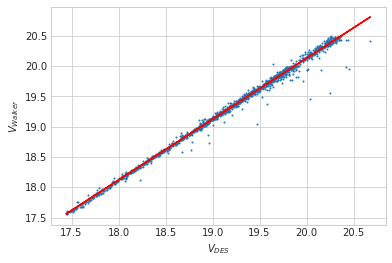

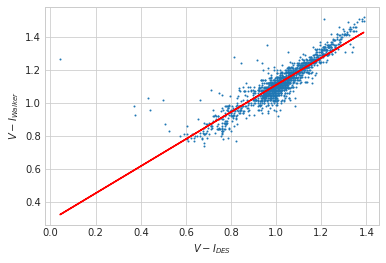

In [102]:
# (V,V-I) fit
from sklearn.linear_model import LinearRegression
lr_v,lr_vmi = LinearRegression(),LinearRegression()
df_walker_fit = df_walker[angles.arcsec<1.0]
df_des_fit = df_des_redden_photometry.iloc[idx[angles.arcsec<1.0]]

v_wlk = df_walker_fit["Vmag"].values
v_des = df_des_fit["Johnson_V"].values
vmi_wlk = df_walker_fit["V-I"].values
vmi_des = df_des_fit["Johnson_V-I"].values

lr_v.fit(v_des.reshape(-1,1),v_wlk)
lr_vmi.fit(vmi_des.reshape(-1,1),vmi_wlk)

plt.scatter(v_des,v_wlk,s=1)
plt.plot(v_des,lr_v.predict(v_des.reshape(-1,1)),c="red")
plt.xlabel("$V_{DES}$")
plt.ylabel("$V_{Walker}$")
plt.show()

plt.scatter(vmi_des,vmi_wlk,s=1)
plt.plot(vmi_des,lr_vmi.predict(vmi_des.reshape(-1,1)),c="red")
plt.xlabel("$V-I_{DES}$")
plt.ylabel("$V-I_{Walker}$")
plt.show()

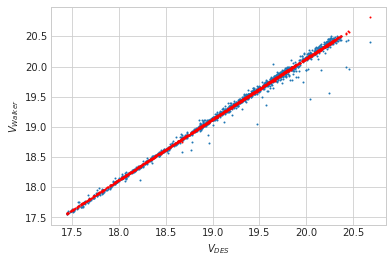

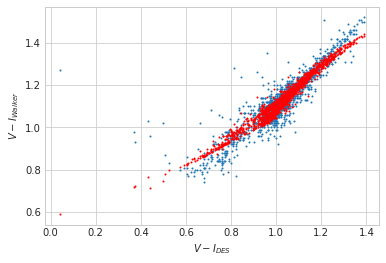

In [104]:
# (V,V-I) fit, matrix form
from sklearn.linear_model import LinearRegression
lr_v,lr_vmi = LinearRegression(),LinearRegression()
df_walker_fit = df_walker[angles.arcsec<1.0]
df_des_fit = df_des_redden_photometry.iloc[idx[angles.arcsec<1.0]]

v_wlk = df_walker_fit["Vmag"].values
v_des = df_des_fit["Johnson_V"].values
vmi_wlk = df_walker_fit["V-I"].values
vmi_des = df_des_fit["Johnson_V-I"].values
v_vmi_des = np.array([v_des,vmi_des]).T

lr_v.fit(v_vmi_des,v_wlk)
lr_vmi.fit(v_vmi_des,vmi_wlk)

plt.scatter(v_des,v_wlk,s=1)
plt.scatter(v_des,lr_v.predict(v_vmi_des),c="red",s=1)
plt.xlabel("$V_{DES}$")
plt.ylabel("$V_{Walker}$")
plt.show()

plt.scatter(vmi_des,vmi_wlk,s=1)
plt.scatter(vmi_des,lr_vmi.predict(v_vmi_des),c="red",s=1)
plt.xlabel("$V-I_{DES}$")
plt.ylabel("$V-I_{Walker}$")
plt.show()

In [ ]:
ret = []
for ra in df_walker.RAdeg.values:
    diff = df_des_photometry.RAP - ra
    idxmin_diff = (np.abs(diff).sort_values()*3600).idxmin() # unit: arcsec
    if diff.iloc[idxmin_diff] < 1.0: # 1 degreee matching
        ret.append(idxmin_diff)

In [ ]:
fig,ax=plt.subplots(1,1)
df_walker.plot.scatter("V-I","Vmag",s=1,ax=ax,c="C0")
df_des_photometry.loc[np.array(ret)].plot.scatter("Johnson_V-I","Johnson_V",s=1,ax=ax,c="C1")
plt.ylim([22,16])
plt.legend(["Walker","MAtfched"])

# MCMC

In [ ]:
dRA = df.RA_deg - modKI17.sculptor_prop.RAdeg
dDE = df.DE_deg - modKI17.sculptor_prop.DEdeg
sculptor = modKI17.modKI17_memonly(
    vs = df.VHel_weighted.values,
    dRAs=dRA.values,dDEs=dDE.values,
    dsph_name="Sculptor",prior_fname="priorconf_sculptor.csv"
)
modKI17.dSph_property

modKI17.DEBUG = False

display(sculptor.params_name)



In [ ]:
p0_base_dic = {"re":228,"dra0":0,"dde0":0,
           "log10_rs_pc":3,"log10_rhos_Msunpc3":0,"a":1,"b":5,"g":1,
           "mlog10_1manib":0,"vmem":110,"dist":100e3}
p0_base = [p0_base_dic[key] for key in sculptor.params_name]
nwalkers = 40
p0 = []
for i in range(nwalkers):
    k = [10,0.01,0.01,1,1,1,1,0.1,1,10,10]
    p0new = p0_base + np.random.rand(11)*np.array(k)
    display(sculptor.lnprob(p0new))
    p0.append(p0new)


In [ ]:
pr = sculptor.prior_lim.loc[sculptor.params_name]
pr_range = (pr.prms_max-pr.prms_min).loc[sculptor.params_name].values
p0 = []
nwalkers = 40
for i in range(1000000):
    if len(p0)>=nwalkers:
        break
    p0_ = np.random.rand(11)*0.0005*pr_range + pr.prms_min
    if sculptor.lnprob(p0_) > -np.inf:
        p0.append(p0_)
        print("{}th point found!".format(len(p0)))
    else:
        continue
#sampler = emcee.sampler

In [ ]:
p0 = sampler.chain[-1][-40:]
p0

In [ ]:
sampler = emcee.EnsembleSampler(40,11,sculptor.lnprob,threads=8)

In [ ]:
"""
for i in range(100):
    pos,prop,state = sampler.run_mcmc(pos, 100)
    sampler.reset()
"""
#pos = p0
for i in [0]*5:
    sampler.reset()
    pos,prop,state = sampler.run_mcmc(pos, 100)
    #display(state)
pos,prop,state = sampler.run_mcmc(pos, 10000)

In [ ]:
res = pd.DataFrame(sampler.flatchain)
display(sculptor.prior_lim.index.values)
res = res.rename(columns={i:sculptor.prior_lim.index.values[i] for i in range(11)})
res["lnprob"] = sampler.flatlnprobability
res.plot(subplots=True,figsize=(12,12),layout=(4,5))
plt.plot()
res[10000:].hist(bins=32,figsize=(8,8))